### scikit-learn
**https://scikit-learn.org**  

API文档——说明  
Examples——例子，可作为参考！
  
包含：  
Classification, Regression, Clustering, Dimensionality reduction, Model selection, Preprocessing

In [41]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

warnings.filterwarnings('ignore')
np.random.seed(42)

### 数据集读取
- 图像数据：(28, 28, 1)的灰度图  
- 数据集ID是 'mnist_784'，OpenML上的OpenML ID  
- 下载到 C:\Users\lenovo\scikit_learn_data ，对应代码如下
```
from sklearn.datasets import get_data_home
get_data_home()
```

In [14]:
from sklearn.datasets import fetch_openml, get_data_home

mnist = fetch_openml(data_id=554, as_frame=False)

In [33]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

维数=28 × 28 × 1

In [16]:
y.shape

(70000,)

In [19]:
X_train, y_train, X_test, y_test = X[: 60000], y[: 600000], X[60000:], y[60000:]

#### 进行洗牌操作

In [20]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

#### 做成二分类任务

In [30]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42)

在测试单个样本时，输入的样本是一个一维数组，要将其改为二维数组才行

In [39]:
sgd_clf.predict(X[3388].reshape(1, -1))
# 或者
sgd_clf.predict([X[3388]])

array([False])

### 交叉验证方法

**cross_val_score**  
`from sklearn.model_selection import cross_val_score `  
只需要传入所有的训练集即可，即 X_train

In [43]:
from sklearn.linear_model import SGDClassifier

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.965  , 0.96455, 0.95535])

#### 不直接用cross_val_score 

**StratifiedKFold**：Stratified(**分层**) K-Fold cross-validator  
· 通过 **split(X, y)** 方法来生成交叉验证集的训练和验证集，返回一个生成器，每次迭代返回两个数组，训练集索引(train_index)和验证集索引(test_index) 

**clone**：construct a new estimator with the same parameters  
SGDClassifier是 在线学习算法，每次调用 fit() 方法时，模型内部参数都会被修改

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    accuracy = n_correct / y_test_folds.shape[0]
    print(accuracy)

0.8751
0.96545
0.94185


### Confusion Matrix-混淆矩阵

#### 交叉验证预测
在每个 flod 中使用部分数据进行训练，并使用另一部分数据进行预测  
**cross_val_predict**

**confusuion_matrix**  
**precision_score**  
**recall_score**   
**f1_score**

In [49]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_predict)

[False False False ... False False False]


In [55]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

conf_matri = confusion_matrix(y_train_5, y_train_predict)

recall = recall_score(y_train_5, y_train_predict)
precision = precision_score(y_train_5, y_train_predict)
f1 = f1_score(y_train_5, y_train_predict)

print(recall, precision, f1)

0.7725511898173769 0.7966520829370364 0.7844165574077544


### 阈值对结果的影响

**decision_function** : predict confidence scores for smaples  
使用想要的阈值，根据得到的分数进行预测  
可以在**cross_val_predict**中的**method**中使用

In [58]:
y_score = sgd_clf.decision_function(X[[3500]])

# 设定阈值
t = 50000

y_pred = (y_score > t)
print(y_pred)

[ True]


**precision_recall_curve**: compute precision-recall pairs for different probability thresholds  
· this implementation is retricted to the binary classification task

In [67]:
y_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
print(y_score[:10])

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_score)

[-329404.63181981 -479700.85219901 -831874.99236885 -331774.89236837
 -563320.52194861 -366977.95308011 -157385.66655133 -112399.92035359
 -552722.80753212 -347284.42226652]


通常 阈值的数量 会比 精度或召回率 少1个

In [68]:
print(y_train.shape, thresholds.shape, precisions.shape, recalls.shape)

(60000,) (60000,) (60001,) (60001,)


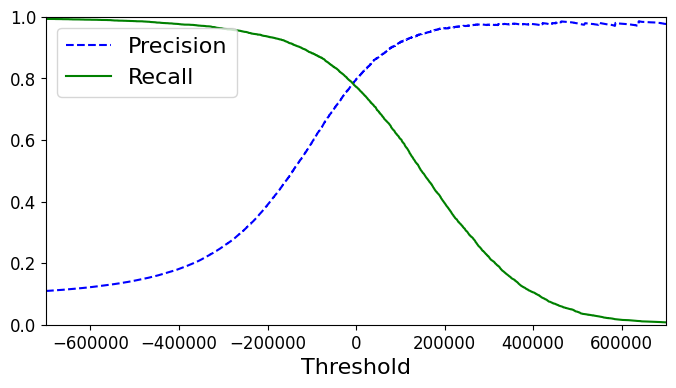

In [71]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,
             precisions[:-1],  #个数要一致，所以要去掉最后一个值
            "b--",
            label="Precision")
    
    plt.plot(thresholds,
             recalls[:-1],
            "g-",
            label="Recall")
    plt.xlabel("Threshold",fontsize=16)
    plt.legend(loc="upper left",fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.xlim([-700000, 700000])
plt.show()

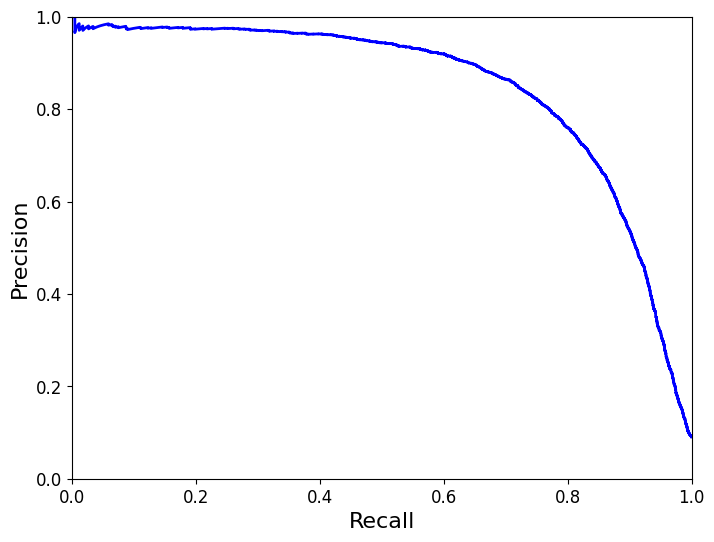

In [72]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, 
             precisions, 
             "b-", 
             linewidth=2)
    
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC曲线
ROC曲线不是绘制precision和recall，而是绘制true positive rate和false positive rate

TPR是y轴，FPR是x轴，一个好的分类器应该尽可能远离y=x  
方法：测量曲线下面积（AUC），完美分类器的ROC AUC等于1，随机分类器的ROC AUC等于0.5

**roc_curve**  
**roc_auc_score**

In [76]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_score)

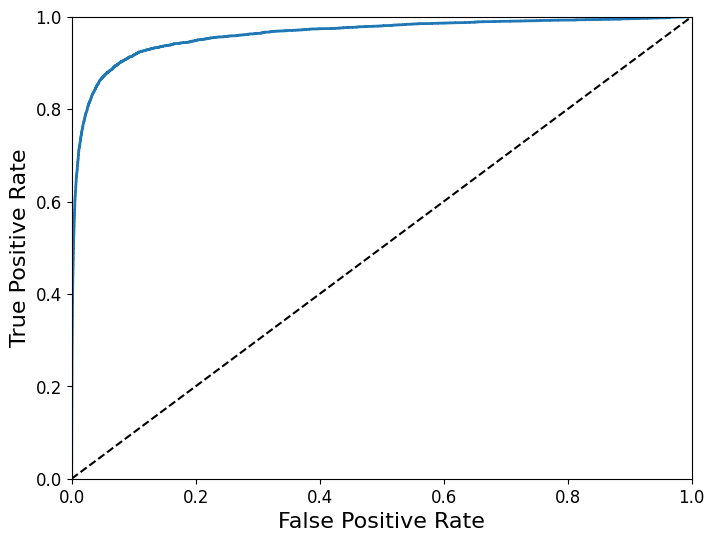

In [77]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [78]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_score)

0.9619712100633097